# 1. Dự báo timeseries với model LSTM 
## 1.1. Giới thiệu chung


## 1.2. Chuỗi dữ liệu

Chuỗi dự liệu được sử dụng trong bài viết là ...... 

Dữ liệu có thể lấy trong ngay bài viết này ở cùng folder với tên file là `data_pro`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

series = pd.read_csv('D:\\Do_an_2\\Project_2\\barycenters_output\\cluster_3_barycenter.csv', sep = ',', header = 0, index_col = 0, names = ['date', 'view'])
series.head()

,view
date,
2022-06-22,0.408
2022-06-23,0.412
2022-06-24,0.241
2022-06-25,0.200
2022-06-26,0.388


Trường `view` chính là lượng khách hàng truy cập và là đại lượng cần được dự báo.

array([[<Axes: title={'center': 'view'}>]], dtype=object)

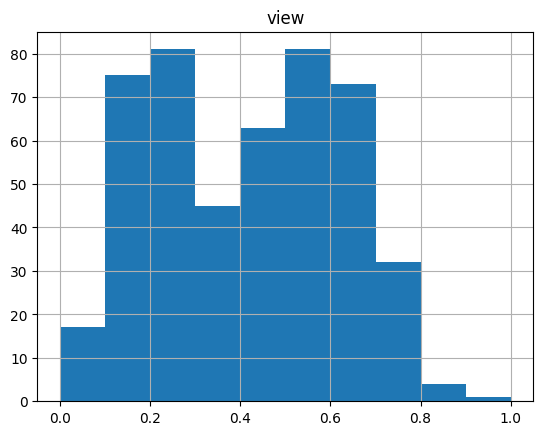

In [2]:
series.hist(bins = 10)

In [3]:
series.describe()

,view
count,472.000000
mean,0.415751
std,0.207870
min,0.000000
25%,0.222000
50%,0.427000
75%,0.592000
max,1.000000


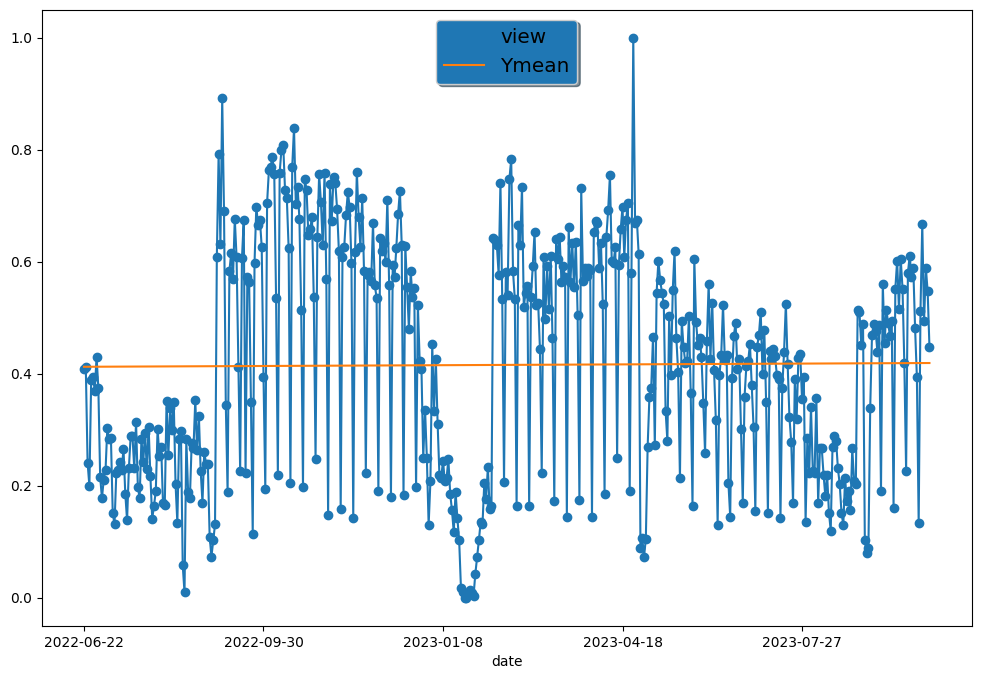

In [4]:
from sklearn import linear_model
import numpy as np
l_reg = linear_model.LinearRegression(fit_intercept = True)
t = np.arange(len(series)).reshape(-1, 1)
l_reg.fit(t, series)
Ymean = l_reg.predict(t)
series.plot(figsize = (12, 8), style = 'o-', label = 'Y')
plt.plot(Ymean, label = 'Ymean')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C0')

# 2. Xây dựng mạng neuron LSTM

## 2.1. Các bước dự báo 

1. Chuẩn bị dữ liệu: Chuẩn hóa dữ liệu đầu vào và chia mẫu train/test.
2. Xây dựng mạng neuron `LSTM`.
3. Lựa chọn hàm loss function và thuật toán gradient descent sử dụng để tìm nghiệm tối ưu.
4. Đánh giá lại mức độ sai số dự báo.
5. Áp dụng model để dự báo cho các khoảng thời gian tiếp theo.

Kết quả model sẽ thay đổi dựa vào số lượng các biến trễ mà ta sử dụng để hồi qui mô hình. Thông thường các biến được sử dụng để dự báo sẽ có độ trễ từ 1 đến 3. Chúng ta không nên lựa chọn độ trễ dài hơn bởi sẽ làm tăng số lượng biến đưa vào mô hình hồi qui và dễ dàng xảy ra hiện tượng overfiting. Hơn nữa việc tăng số lượng biến làm tăng khối lượng tính toán và làm tăng chi phí thời gian. Bên dưới chúng ta sẽ xây dựng model LSTM cho 3 độ trễ là 1 tháng, 3 tháng và đánh giá sai số dự báo của mô hình.

## 2.2. Xây dựng mạng LSTM với biến trễ 1 tháng

Chúng ta coi chuỗi dữ liệu hiện tại ứng với thời điểm t là biến được dự báo và giá trị trễ của nó là (t-1) là biến dự báo. Các biến này sẽ được `Scale` trong khoảng (0,1) để thuật toán `gradient descent` hội tụ nhanh hơn và không bị nhảy khỏi các điểm global optimal points.

Tạo hàm `create_shift_series` khởi tạo data frame chứa chuỗi hiện tại và trễ của nó.

In [5]:
def create_shift_series(series, look_back):
    data_shift = series
    cols = ['X']
    for i in range(look_back):
        data_shift = pd.merge(data_shift, series.shift(i+1), how = 'left', left_index = True, right_index = True)
        cols.append('X%s'%(i+1))
    data_shift.columns = cols
    data_shift.fillna(0, inplace = True)
    return data_shift.iloc[look_back:, :]

In [6]:
data_shift = create_shift_series(series = series, look_back = 1)
data_shift.head()

,X,X1
date,,
2022-06-23,0.412,0.408
2022-06-24,0.241,0.412
2022-06-25,0.200,0.241
2022-06-26,0.388,0.200
2022-06-27,0.394,0.388


`Scale` dữ liệu theo phương pháp `MinMaxScaler` để các giá trị của biến dự báo và được dự báo nằm trong khoảng (0, 1) và chia mẫu train/test.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_shift)
#split into train and test sets
train_size = int(len(data_shift)*2/3)
test_size = len(data_shift) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print('Train shape: %s ; Test shape: %s'%(train.shape, test.shape))
print('Train 5 first rows: \n %s,\nTest 5 first rows: \n %s '%(train[:5], test[:5]))

Train shape: (314, 2) ; Test shape: (157, 2)
Train 5 first rows: 
 [[0.412 0.408]
 [0.241 0.412]
 [0.2   0.241]
 [0.388 0.2  ]
 [0.394 0.388]],
Test 5 first rows: 
 [[0.359 0.269]
 [0.375 0.359]
 [0.466 0.375]
 [0.272 0.466]
 [0.545 0.272]] 


In [8]:
trainX, trainY = train[:, 1], train[:, 0]
testX, testY = test[:, 1], test[:, 0]

Chúng ta cần reshape lại dữ liệu theo kích thước 3D với các chiều lần lượt là `[samples, time_steps, features]` trong đó:
* samples: Số lượng các quan sát được sử dụng làm input dự báo.
* time_steps: Bước nhảy thời gian giữa 2 quan sát liên tiếp của biến được dự báo.
* features: Số lượng các biến dự báo được sử dụng trong model.
Các ma trận sẽ được reshape lại như sau:

In [9]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape(trainX.shape[0], 1, 1)
testX = testX.reshape(testX.shape[0], 1, 1)

Xây dựng mạng neuron `LSTM`. Mô hình mạng neuron này bao gồm 1 layer LSTM với 60 units được kết nối trực tiếp với một fully connected layer với 1 unit duy nhất chính là đầu ra của kết quả dự báo. Thuật toán được sử dụng để cập nhật nghiệm là `Adam` và hàm loss function được lựa chọn là `mean_squared_error`.

In [10]:
# Create LSTM model
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
import numpy as np

look_back = 1
model = Sequential()
model.add(LSTM(60, input_shape = (1, look_back)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.fit(trainX, trainY, epochs = 100, batch_size = 32, verbose = 0, shuffle = False)

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Dự báo kết quả trên tập train và trên tập test từ mạng neuron vừa xây dựng. Kết quả thu được cần được chuyển hóa ngược từ hàm `scale` ban đầu để ra được giá trị dự báo cho chuỗi thời gian do đầu vào của chúng ta đã được scale.

In [11]:
# Make prediction
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# Invert prediction
trainPredictInv = scaler.inverse_transform(np.concatenate((trainPredict, trainX.reshape(trainX.shape[0], -1)), axis = 1))[:, 0]
trainYInv = data_shift.iloc[:train_size, 0].values
testPredictInv = scaler.inverse_transform(np.concatenate((testPredict, testX.reshape(testX.shape[0], -1)), axis = 1))[:, 0]
testYInv = data_shift.iloc[train_size:, 0].values

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [12]:
# Root mean squared error
mse_train = math.sqrt(mean_squared_error(trainYInv[:-1], trainPredictInv[1:]))
mse_test = math.sqrt(mean_squared_error(testYInv[:-1], testPredictInv[1:]))
print('Train MSE: %s' %mse_train)
print('Test MSE: %s' %mse_test)

Train MSE: 0.08840080801663898
Test MSE: 0.05924082839917539


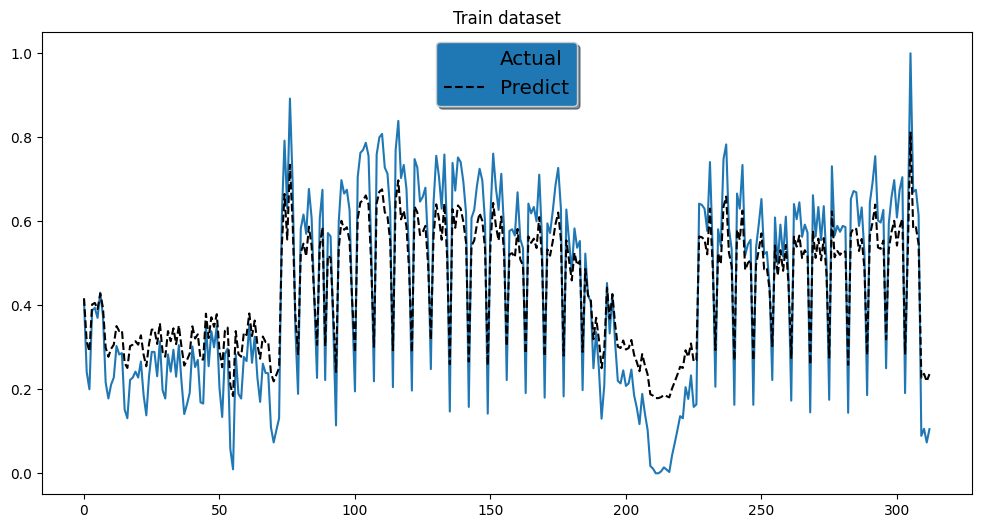

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(trainYInv[:-1], label = 'Actual')
plt.plot(trainPredictInv[1:], 'k--', label = 'Predict')
plt.title('Train dataset')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C0')

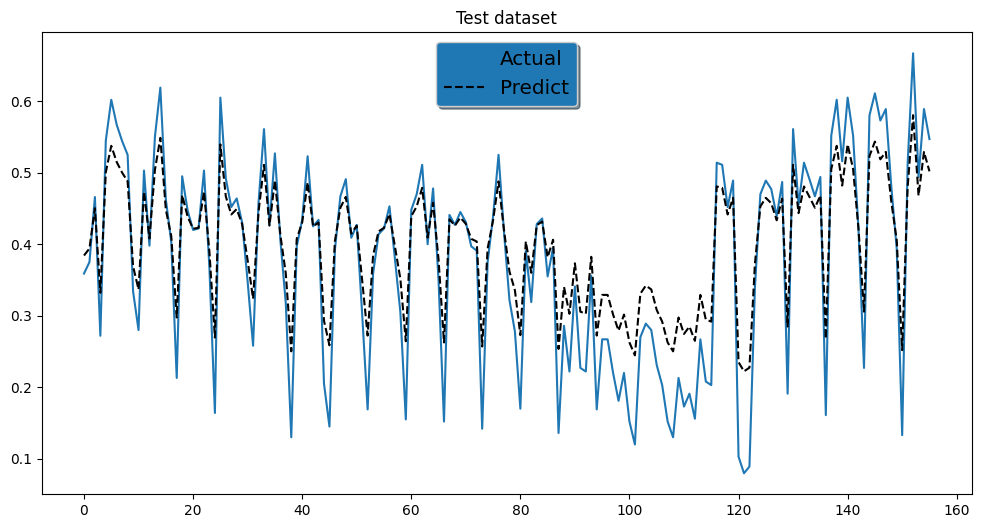

In [14]:
plt.figure(figsize = (12, 6))
plt.plot(testYInv[:-1], label = 'Actual')
plt.plot(testPredictInv[1:], 'k--', label = 'Predict')
plt.title('Test dataset')
legend = plt.legend(loc = 'upper center', shadow = True, fontsize = 'x-large')
legend.get_frame().set_facecolor('C0')


## 2.5. Tài liệu tham khảo

Tài liệu tham khảo:

1. [Sơ đồ model LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

2. [Blog machinelearningmastery của Jason Brownlee](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras)

3. [Tổng hợp các phương pháp dự báo timeseries](https://www.datascience.com/blog/time-series-forecasting-machine-learning-differences)

4. [Dự báo timeseries trafic kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting)

5. [LSTM dự báo timeseries blog towardsdatascience](https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f)

6. [Dự báo giá S&P500 sử dụng LSTM](https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks)